In [91]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import time

To avoid extra calculus we set a "verbose_analysis" variable that is in charge to run or not the analysis code.

In [92]:
verbose_analysis = False

Let us first read the train and test files

In [93]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

We create a SIFT object detector and descriptor

In [94]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=950)

**Test other amounts of local features**

We have tested values from 25 to 2000 
As a result we have been able to obtain the following graph with which we can observe a logaritmic. 
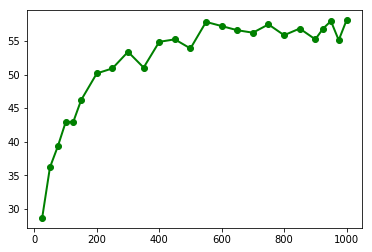

The conclusion is, that if we have features you do not have information and the result is worse, as you increase them the % goes up to 59.2 and from that value it goes down again, because it becomes redundant and more difficult to classify.

In [95]:
if verbose_analysis:
    nfeatures_list = [25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 925, 950, 975, 1000]
    accuracies = list()
    for nfeatures in nfeatures_list:
        print(nfeatures)
        SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures)

        Train_descriptors = []
        Train_label_per_descriptor = []

        for filename,labels in zip(train_images_filenames,train_labels):
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=SIFTdetector.detectAndCompute(gray,None)
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D=np.vstack(Train_descriptors)

        k = 64
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)

        visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words=codebook.predict(Train_descriptors[i])
            visual_words[i,:]=np.bincount(words,minlength=k)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
        for i in range(len(test_images_filenames)):
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=SIFTdetector.detectAndCompute(gray,None)
            words=codebook.predict(des)
            visual_words_test[i,:]=np.bincount(words,minlength=k)

        accuracy = 100*knn.score(visual_words_test, test_labels)

        accuracies.append(accuracy)

        print('For nfeatures=' + str(nfeatures) + ' the accuracy is: ' + str(accuracy))
    plt.plot(nfeatures_list, accuracies, 'go-', label='line 1', linewidth=2)
    plt.show()

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [96]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We compute the Dense SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together. In this case, we just fill in the keypoint array yourself by making a grid a keypoints using diferents size between them. Then a descriptor will be calculated for each keypoint when you pass the keypoints to sift.compute().
Depending on the size of the image and the speed of our machine, this might take a very long time. This is the reason that we taking in count the procesing time, for each size of pixels spacing between kp's we know the copmutational time.

In [79]:
Train_descriptors = []
Train_label_per_descriptor = []
step_size= 25
for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
        kpt,des=SIFTdetector.compute(gray,kp)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We evaluated the descriptor with a range from 25 to 100. In the next plot show the results obtained ant we check that with the step_size of 25 we obtained 74.59 points of accuracy that is quite good ratio. But in the other hand, with this size the time procesing is high so we have to chose between accuracy or time procesing. In fact, if we check the plotted figure we find a compromised between them, with step_size of 65 we obtain time procesing of 58.56 and acuracy of 64.93.
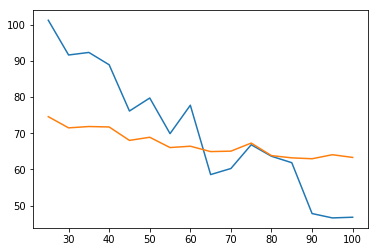

Initialy the SIFT descriptor have 50.92 of acurracy and 90.957 time procesing. In compair with this values we obted a betters mark of accuracy with Dense SIFT with low time procesing than SIFT. We asumed that to not use keypoints of SIFT it was decreasing time but not believed that this could be improve the acuracy.

In [105]:
if verbose_analysis:
    type_step_size = [25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,85,90,95,100]

    Time_list = list()
    accuracy_list = list()

    for step_size in type_step_size:
        print(step_size)
        start = time.time()
        Train_descriptors = []
        Train_label_per_descriptor = []
        for filename,labels in zip(train_images_filenames,train_labels):
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
            kpt,des=SIFTdetector.compute(gray,kp)
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D=np.vstack(Train_descriptors)
        k = 128
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)

        visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words=codebook.predict(Train_descriptors[i])
            visual_words[i,:]=np.bincount(words,minlength=k)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels) 

        visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
        for i in range(len(test_images_filenames)):
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
            #kp=dense.detect(gray)
            kpt,des=SIFTdetector.compute(gray,kp)
            words=codebook.predict(des)
            visual_words_test[i,:]=np.bincount(words,minlength=k)
        end = time.time()
        tTime= end - start
        print ("step_size:" ,step_size)
        print('Total time:',tTime)    
        accuracy = 100*knn.score(visual_words_test, test_labels)
        print(accuracy)
        Time_list.append(tTime)
        accuracy_list.append(accuracy)

    plt.plot(type_step_size, Time_list)
    plt.plot(type_step_size, accuracy_list)
    plt.show()

We now compute a k-means clustering on the descriptor space with the best number of clusters

In [98]:
k = 140
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2800, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=140, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

**Test different amounts of codebook sizes k**

First we have tested powers of 2 from 2 to 2048, but then we have been able to see that near ~100 was already going well so we have discarded the experiment of the powers of 2 and he has been passed to a vector near those values, what we see is that the success fluctuates between 50 and little up to 56 approximately depending on the value. The conclusion here is that only a small variation improves the result.
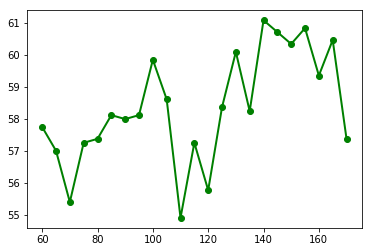
As we can see changing the value of k of 128 to 140 we obtained a considerable improvement.

In [99]:
if verbose_analysis:
    k_list = [60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170]
    accuracies = list()
    for k in k_list:
        print(k)
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)

        visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words=codebook.predict(Train_descriptors[i])
            visual_words[i,:]=np.bincount(words,minlength=k)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
        for i in range(len(test_images_filenames)):
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=SIFTdetector.detectAndCompute(gray,None)
            words=codebook.predict(des)
            visual_words_test[i,:]=np.bincount(words,minlength=k)

        accuracy = 100*knn.score(visual_words_test, test_labels)
        accuracies.append(accuracy)
        print('For k=' + str(k) + ' the accuracy is: ' + str(accuracy))
    plt.plot(k_list, accuracies, 'go-', label='line 1', linewidth=2)
    plt.show()

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [100]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We test differents values to find the best parameters to classify with knn.

In [101]:
 if verbose_analysis:
    metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    k_values = list(range(1, 21))
    is_k_analisys = False
    is_metric_analisys = True
    results_accuracy = list()

    if is_k_analisys:
        for kl in k_values:
            print(kl)
            knn = KNeighborsClassifier(n_neighbors=kl, n_jobs=-1, metric='minkowski')
            knn.fit(visual_words, train_labels)

            visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
            for i in range(len(test_images_filenames)):
                filename = test_images_filenames[i]
                ima = cv2.imread(filename)
                gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
                kpt, des = SIFTdetector.detectAndCompute(gray, None)
                words = codebook.predict(des)
                visual_words_test[i, :] = np.bincount(words, minlength=k)

            accuracy = 100 * knn.score(visual_words_test, test_labels)
            results_accuracy.append(accuracy)
        plt.plot(k_values, results_accuracy, 'go-', label='line 1', linewidth=2)
        plt.show()

    if is_metric_analisys:
        for met in metrics:
            print(met)
            knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric=met)
            knn.fit(visual_words, train_labels)



            visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
            for i in range(len(test_images_filenames)):
                filename = test_images_filenames[i]
                ima = cv2.imread(filename)
                gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
                kpt, des = SIFTdetector.detectAndCompute(gray, None)
                words = codebook.predict(des)
                visual_words_test[i, :] = np.bincount(words, minlength=k)

            accuracy = 100 * knn.score(visual_words_test, test_labels)
            results_accuracy.append(accuracy)
        plt.plot(metrics, results_accuracy, 'go-', label='line 1', linewidth=2)
        plt.show()

**Test other distances for the k-nn classifier**

The distances used for test the Knn classifier:

| identifier  | distance function           |
|-------------|-----------------------------|
| euclidean   | sqrt(sum((x - y)^2))        |
| manhattan   | sum(\|x - y\|)                |
| chebyshev   | max(\|x - y\|)                |
| minkowski   | sum(\|x - y\|^p)^(1/p)        |


As a result we obtained that the best distance fuction is euclidean or minkowski
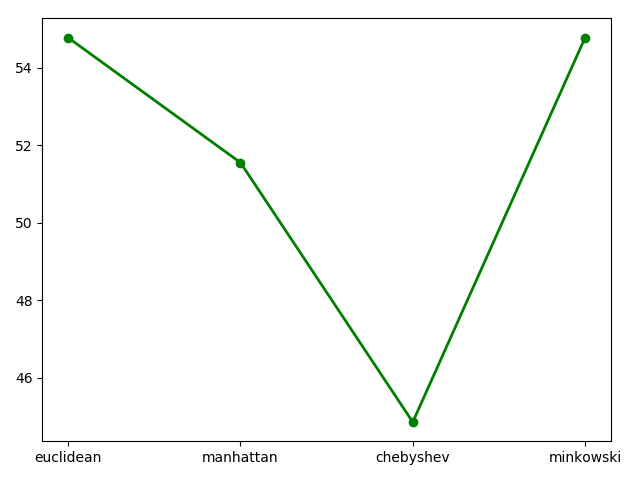

**Test different values of k for the k-nn classifier**

We iterate around 1 to 20 the n_neighbords in order to find the best value that aproxime our model. Taking inot account that when n_neighbords is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. A higher n_neighbords averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias.
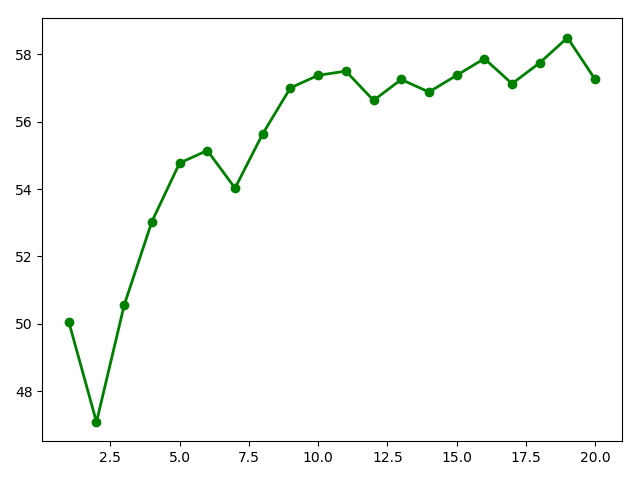
As a result we obtained that the best n_neighbords is 19 fixing metric with minkowski or euclidean.

After analysing the two variables we can conclude that is better find first the best distance and after fix the metric in order to iterate over n_neighbords.

We build a k-nn classifier with the best parameters and train it with the train descriptors

In [102]:
knn = KNeighborsClassifier(n_neighbors=19,n_jobs=-1,metric='minkowski')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=19, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [103]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [106]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

61.957868649318456


The best result with sift is 61 but dense isft without analisys of best parametres is capable to obtain 74. For this reason we can conclude that the best way to improve the acuracy is select the best method to detect the keypoints and descriptors. 